# Text Analyses with Tensor Flow in Keras
---

![text-analysis-fb.png](assets/text-analysis-fb.png)

## Introduction

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem. 

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews. 

This notebook uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow, and [TensorFlow Hub](https://www.tensorflow.org/hub), a library and platform for transfer learning. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

## Initial Set-Up

In [ ]:
#!conda install keras
#!pip install tensorflow
#!pip install tensorflow_hub
#!pip install tensorflow_datasets

In [26]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


## Downloading The Data

In [27]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

# Exploring The Data

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review. These labels are kept separate from the training data (aka the examples). 

In [28]:
# Checking the length of the training and test sets. 
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


In [29]:
# Looking at the first 5 examples. 
train_examples[:5]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

In [30]:
# Looking at the first 5 labels. 
train_labels[:5]

array([0, 0, 0, 1, 1])

# Building the Model

A neural network is created by stacking layers. This requires three main architectural decisions:

- How to represent the text?
- How many layers to use in the model?
- How many hidden units to use for each layer?

In this example, the input data consists of sentences. The labels to predict sentiment are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. 

We can use a pre-trained text embedding as the first layer, which will have two advantages:
- we don't have to worry about text preprocessing,
- we can benefit from transfer learning.

For this example we will use a model from TensorFlow Hub called google/nnlm-en-dim50/2.

In [31]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"

### Creating First Keras Layer
Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences. 

In [32]:
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

### Building The Full Model

The layers are stacked sequentially to build the classifier:

The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The model that we are using (google/nnlm-en-dim50/2) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: (num_examples, embedding_dimension).

This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

The last layer is densely connected with a single output node. This outputs logits: the log-odds of the true class, according to the model.

In [33]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_4 (Dense)             (None, 16)                816       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called overfitting.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. 

Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the binary_crossentropy loss function.

This isn't the only choice for a loss function, you could, for instance, choose mean_squared_error. But, generally, binary_crossentropy is better for dealing with probabilities. It measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Now, configure the model to use an optimizer and a loss function:

In [34]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

# Creating a Validation Set

When training, we want to check the accuracy of the model on data it hasn't seen before. We can create a validation set by setting apart 10,000 examples from the original training data. We do not want to use the testing set now because our goal is to develop and tune our model using only the training data, and then use the test data just once to evaluate our accuracy.

In [35]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

# Training the Model

We are going to train the model for 40 epochs in mini-batches of 512 samples. 

This is 40 iterations over all samples in the x_train and y_train tensors. 

While training, we will monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [36]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 25s 814ms/step - loss: 0.6712 - accuracy: 0.5997 - val_loss: 0.6283 - val_accuracy: 0.6993
Epoch 2/40
30/30 [==============================] - 24s 804ms/step - loss: 0.5758 - accuracy: 0.7656 - val_loss: 0.5441 - val_accuracy: 0.7777
Epoch 3/40
30/30 [==============================] - 24s 809ms/step - loss: 0.4672 - accuracy: 0.8393 - val_loss: 0.4521 - val_accuracy: 0.8247
Epoch 4/40
30/30 [==============================] - 24s 819ms/step - loss: 0.3512 - accuracy: 0.8889 - val_loss: 0.3765 - val_accuracy: 0.8496
Epoch 5/40
30/30 [==============================] - 24s 797ms/step - loss: 0.2571 - accuracy: 0.9193 - val_loss: 0.3345 - val_accuracy: 0.8633
Epoch 6/40
30/30 [==============================] - 24s 819ms/step - loss: 0.1902 - accuracy: 0.9425 - val_loss: 0.3110 - val_accuracy: 0.8722
Epoch 7/40
30/30 [==============================] - 24s 814ms/step - loss: 0.1387 - accuracy: 0.9625 - val_loss: 0.3042 - val_accuracy: 0.8749

# Evaluating the Model

To see how the model performs, we can consider two values: Loss and Accuracy. Loss is a number that represents error and lower values are better. Accuracy is the number of correct predictions whenc ompared to our labels. 

In [13]:
results = model.evaluate(test_examples, test_labels)

print(results)

782/782 [==============================] - 94s 121ms/step - loss: 0.5963 - accuracy: 0.8473
[0.5962553024291992, 0.8472800254821777]


# Checking Loss and Accuracy

When we used model.fit() it returned a History object that contains a dictionary with everything that happened during training. 

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy.

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

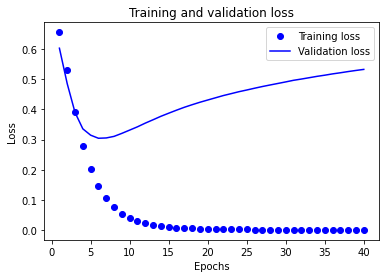

In [16]:
# Generating Loss Plot

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

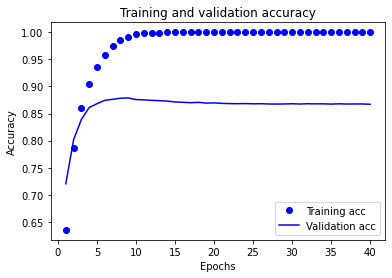

In [17]:
plt.clf()   # clearing previous figure

# Generating Accuracy Plot
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# First Model Findings

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. 

This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. 

# Trying A Different Model

Let's change the model to 20 epochs to see if we can improve it. 

In [18]:
model = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"

In [19]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [21]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 23s 757ms/step - loss: 0.4871 - accuracy: 0.9169 - val_loss: 0.4618 - val_accuracy: 0.8494
Epoch 2/20
30/30 [==============================] - 23s 774ms/step - loss: 0.2846 - accuracy: 0.9905 - val_loss: 0.3551 - val_accuracy: 0.8663
Epoch 3/20
30/30 [==============================] - 23s 762ms/step - loss: 0.1536 - accuracy: 0.9954 - val_loss: 0.3084 - val_accuracy: 0.8744
Epoch 4/20
30/30 [==============================] - 23s 761ms/step - loss: 0.0798 - accuracy: 0.9982 - val_loss: 0.3022 - val_accuracy: 0.8761
Epoch 5/20
30/30 [==============================] - 22s 752ms/step - loss: 0.0481 - accuracy: 0.9991 - val_loss: 0.3095 - val_accuracy: 0.8753
Epoch 6/20
30/30 [==============================] - 23s 753ms/step - loss: 0.0320 - accuracy: 0.9994 - val_loss: 0.3202 - val_accuracy: 0.8751
Epoch 7/20
30/30 [==============================] - 22s 749ms/step - loss: 0.0225 - accuracy: 0.9999 - val_loss: 0.3317 - val_accuracy: 0.8761

In [22]:
results = model.evaluate(test_examples, test_labels)

print(results)

782/782 [==============================] - 107s 137ms/step - loss: 0.4984 - accuracy: 0.8498
[0.4984038174152374, 0.8497599959373474]


In [23]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

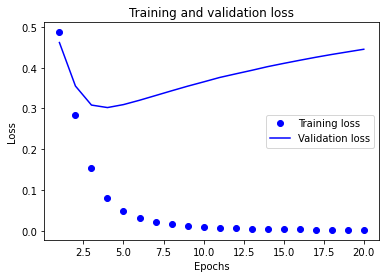

In [24]:
# Generating Loss Plot

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

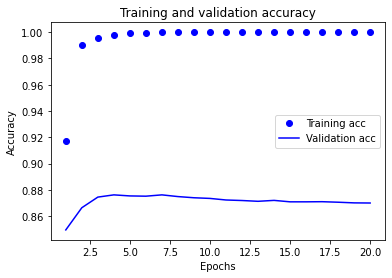

In [25]:
plt.clf()   # clearing previous figure

# Generating Accuracy Plot
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()